In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import warnings
warnings.filterwarnings('ignore')

register_matplotlib_converters()
%matplotlib inline

In [28]:
import psycopg2


postgresDb = psycopg2.connect(
    host="localhost",
    database="postgres",
    user="postgres",
    password="admin")

In [29]:
class Stockdatadao:
    def __init__(self, db):
        self.db = db

    def select(self, symbol):
        cursor = self.db.cursor()
        sql = """SELECT date_time, open, high, low, close, volume, adj_close
                    FROM stock_data WHERE symbol = %s"""
        val = (symbol,)

        cursor.execute(sql, val)
        result = cursor.fetchall()
        list_stock_data = []

        for item in result:
            list_stock_data.append(
                StockDataViewModel(date_time=item[0], open=item[1], high=item[2], low=item[3],
                                   close=item[4], volume=item[5], adj_close=item[6]))

        cursor.close()
        if result is None:
            return None
        else:
            return list_stock_data


class StockDataViewModel:
    def __init__(self, date_time, open, high, low, close, volume, adj_close):
        self.date_time = date_time
        self.open = open
        self.high = high
        self.low = low
        self.close = close
        self.volume = volume
        self.adj_close = adj_close

    def to_dict(self):
        return {
            'date_time': self.date_time,
            'open': self.open,
            'high': self.high,
            'low': self.low,
            'close': self.close,
            'volume': self.volume,
            'adj_close': self.adj_close
        }

In [30]:
stock_data_dao = Stockdatadao(postgresDb)
stock_data = stock_data_dao.select('GOOGL')

temp_df = pd.DataFrame.from_records([s.to_dict() for s in stock_data])

temp_df['date_time'] = pd.to_datetime(temp_df['date_time'], utc=True, format="ISO8601")
temp_df["date_time"] = temp_df["date_time"].dt.strftime("%Y-%m-%d")
temp_df.index = pd.DatetimeIndex(temp_df["date_time"]) #assign the changed column to the index
temp_df.sort_index(inplace=True)
temp_df = temp_df.loc['2005-01-10':'2023-07-07']
print(len(temp_df))
temp_df.tail(3)

4654


,date_time,open,high,low,close,volume,adj_close
date_time,,,,,,,
2023-07-05,2023-07-05,119.239998,122.610001,119.230003,121.750000,27584800.0,121.750000
2023-07-06,2023-07-06,119.800003,120.300003,118.400002,120.110001,24745200.0,120.110001
2023-07-07,2023-07-07,120.099998,121.050003,119.400002,119.480003,21692600.0,119.480003


In [31]:
#get the dataset from the csv file into df
df = pd.read_csv('/mnt/learning/last_project/fetch_data_stock/input/clean_google.csv')
print(len(df))
df.tail(3)

4654


,Date,Open,High,Low,Close,Volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,...,BBM_3_2.0,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8
4651,2023-07-05 00:00:00-04:00,119.239998,122.610001,119.230003,121.750000,27584800,2.142701,77.001957,37.303969,100.000000,...,120.449999,122.295716,3.064702,0.852167,118.820000,122.610001,120.920002,121.697906,126.316152,120.397993
4652,2023-07-06 00:00:00-04:00,119.800003,120.300003,118.400002,120.110001,24745200,2.480533,45.481695,28.805801,-51.585600,...,120.586667,122.240779,2.743440,0.355915,118.400002,122.610001,119.350002,120.243402,126.353948,120.279933
4653,2023-07-07 00:00:00-04:00,120.099998,121.050003,119.400002,119.480003,21692600,1.937299,36.801333,29.903724,-30.094726,...,120.446668,122.360289,3.177541,0.247425,118.400002,122.610001,120.225002,119.464553,126.348083,119.879878


In [32]:
#rename the column in df

df = df.rename(columns={'Volume': 'volume',
                        'Open': 'open', 'High': 'high',
                        'Low': 'low', 'Close': 'close', 'Date':'date'})

df.head(2)

,date,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,...,BBM_3_2.0,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8
0,2005-01-10 00:00:00-05:00,4.867367,4.957457,4.800551,4.881381,301282416,3.297238,58.767641,42.870467,100.000000,...,4.816983,4.958482,5.874972,0.727556,4.697698,4.957457,4.879004,4.883820,3.863238,4.850060
1,2005-01-11 00:00:00-05:00,4.895395,4.947698,4.834334,4.843343,278069652,2.831877,48.714336,37.850269,44.635922,...,4.858608,4.891431,1.351113,0.267455,4.724224,4.957457,4.891016,4.848029,3.920317,4.842952


In [33]:
#Change the type of the date column from object to datetime in df

df['date'] = pd.to_datetime(df['date'], utc=True)
df["date"] = df["date"].dt.strftime("%Y-%m-%d")
df.index = pd.DatetimeIndex(df["date"]) #assign the changed column to the index
df.sort_index(inplace=True)
df.last('3D')

,date,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,...,BBM_3_2.0,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8
date,,,,,,,,,,,,,,,,,,,,,
2023-07-05,2023-07-05,119.239998,122.610001,119.230003,121.750000,27584800,2.142701,77.001957,37.303969,100.000000,...,120.449999,122.295716,3.064702,0.852167,118.820000,122.610001,120.920002,121.697906,126.316152,120.397993
2023-07-06,2023-07-06,119.800003,120.300003,118.400002,120.110001,24745200,2.480533,45.481695,28.805801,-51.585600,...,120.586667,122.240779,2.743440,0.355915,118.400002,122.610001,119.350002,120.243402,126.353948,120.279933
2023-07-07,2023-07-07,120.099998,121.050003,119.400002,119.480003,21692600,1.937299,36.801333,29.903724,-30.094726,...,120.446668,122.360289,3.177541,0.247425,118.400002,122.610001,120.225002,119.464553,126.348083,119.879878


In [34]:
#drop column date if it exists in df

if 'date' in df.columns:
    df.drop(['date'], axis=1, inplace=True)

#check for null values in df
df.isnull().sum()

open             0
high             0
low              0
close            0
volume           0
NATR_3           0
RSI_3            0
ADX_3            0
CCI_3_0.015      0
ROC_3            0
STOCHk_14_3_3    0
STOCHd_14_3_3    0
WILLR_3          0
OBV              0
MACD_12_26_9     0
BBL_3_2.0        0
BBM_3_2.0        0
BBU_3_2.0        0
BBB_3_2.0        0
BBP_3_2.0        0
min_price_3      0
max_price_3      0
mid_price        0
tema_2           0
tema_100         0
tema_8           0
dtype: int64

In [35]:
#add adj_close into main df

df['adj_close'] = temp_df['adj_close']
df.head(2)

,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,adj_close
date,,,,,,,,,,,,,,,,,,,,,
2005-01-10,4.867367,4.957457,4.800551,4.881381,301282416,3.297238,58.767641,42.870467,100.000000,0.800973,...,4.958482,5.874972,0.727556,4.697698,4.957457,4.879004,4.883820,3.863238,4.850060,4.881381
2005-01-11,4.895395,4.947698,4.834334,4.843343,278069652,2.831877,48.714336,37.850269,44.635922,2.646507,...,4.891431,1.351113,0.267455,4.724224,4.957457,4.891016,4.848029,3.920317,4.842952,4.843343


In [36]:
#check for null values in df
df.isnull().sum()

open             0
high             0
low              0
close            0
volume           0
NATR_3           0
RSI_3            0
ADX_3            0
CCI_3_0.015      0
ROC_3            0
STOCHk_14_3_3    0
STOCHd_14_3_3    0
WILLR_3          0
OBV              0
MACD_12_26_9     0
BBL_3_2.0        0
BBM_3_2.0        0
BBU_3_2.0        0
BBB_3_2.0        0
BBP_3_2.0        0
min_price_3      0
max_price_3      0
mid_price        0
tema_2           0
tema_100         0
tema_8           0
adj_close        0
dtype: int64

In [37]:
null_values = df[df['adj_close'].isnull()]

# Print the resulting dataframe containing the null values
print(null_values)

Empty DataFrame
Columns: [open, high, low, close, volume, NATR_3, RSI_3, ADX_3, CCI_3_0.015, ROC_3, STOCHk_14_3_3, STOCHd_14_3_3, WILLR_3, OBV, MACD_12_26_9, BBL_3_2.0, BBM_3_2.0, BBU_3_2.0, BBB_3_2.0, BBP_3_2.0, min_price_3, max_price_3, mid_price, tema_2, tema_100, tema_8, adj_close]
Index: []

[0 rows x 27 columns]


In [38]:
df['volume'] = df['volume'].astype(float)

In [39]:
###get the dataset of apple stock from 2013-01-01 to 2023-06-01 from df
df = df.loc['2013-01-01':'2023-06-29']
df.index

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-14', '2013-01-15',
               ...
               '2023-06-15', '2023-06-16', '2023-06-20', '2023-06-21',
               '2023-06-22', '2023-06-23', '2023-06-26', '2023-06-27',
               '2023-06-28', '2023-06-29'],
              dtype='datetime64[ns]', name='date', length=2641, freq=None)

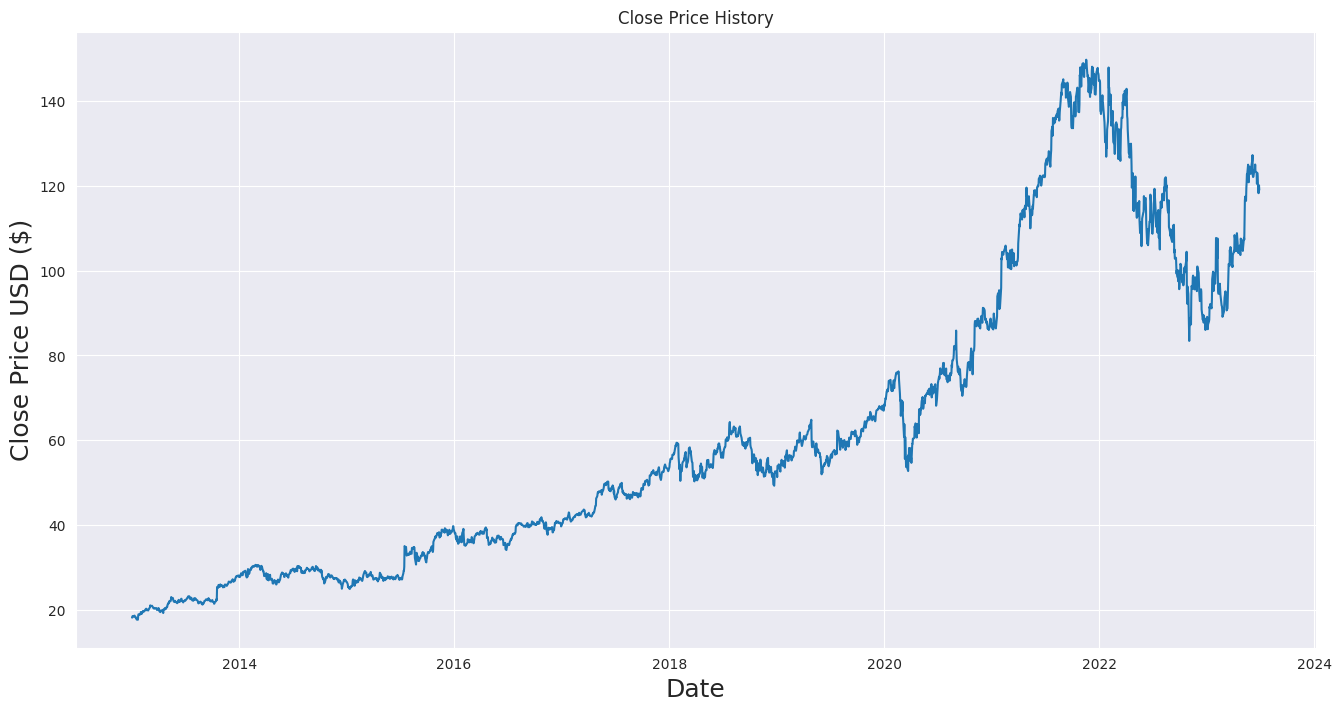

In [40]:
###plot the close price history of AAPL stock from 2013-01-01 to 2023-06-01 from df using matplotlib

plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2641 entries, 2013-01-02 to 2023-06-29
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           2641 non-null   float64
 1   high           2641 non-null   float64
 2   low            2641 non-null   float64
 3   close          2641 non-null   float64
 4   volume         2641 non-null   float64
 5   NATR_3         2641 non-null   float64
 6   RSI_3          2641 non-null   float64
 7   ADX_3          2641 non-null   float64
 8   CCI_3_0.015    2641 non-null   float64
 9   ROC_3          2641 non-null   float64
 10  STOCHk_14_3_3  2641 non-null   float64
 11  STOCHd_14_3_3  2641 non-null   float64
 12  WILLR_3        2641 non-null   float64
 13  OBV            2641 non-null   float64
 14  MACD_12_26_9   2641 non-null   float64
 15  BBL_3_2.0      2641 non-null   float64
 16  BBM_3_2.0      2641 non-null   float64
 17  BBU_3_2.0      2641 non-null   flo

In [42]:
#We need to restructure the data set by adding a target column ‘Actual’, which will the stock prices for the next day.

steps=-1
main_dataset = df.copy()
main_dataset['Next date'] = main_dataset['close'].shift(steps)
main_dataset.last('3D')

,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,adj_close,Next date
date,,,,,,,,,,,,,,,,,,,,,
2023-06-27,117.080002,119.080002,116.099998,118.330002,39535900.0,2.720893,19.186960,74.068793,-87.759074,-3.913926,...,6.310615,0.322562,116.099998,122.790001,117.590000,118.182025,125.994884,118.675051,118.330002,120.180000
2023-06-28,117.089996,120.389999,116.849998,120.180000,27091400.0,2.812296,49.333057,62.778869,30.188737,-1.765568,...,2.924763,0.853550,116.099998,122.000000,118.619999,120.061942,126.077394,118.984788,120.180000,119.099998
2023-06-29,119.239998,120.059998,118.300003,119.099998,24090900.0,2.208150,37.185949,55.252253,50.763377,0.642219,...,2.546187,0.465954,116.099998,120.389999,119.180000,119.214513,126.088071,118.685920,119.099998,NaN


In [43]:
main_dataset.isnull().sum()

open             0
high             0
low              0
close            0
volume           0
NATR_3           0
RSI_3            0
ADX_3            0
CCI_3_0.015      0
ROC_3            0
STOCHk_14_3_3    0
STOCHd_14_3_3    0
WILLR_3          0
OBV              0
MACD_12_26_9     0
BBL_3_2.0        0
BBM_3_2.0        0
BBU_3_2.0        0
BBB_3_2.0        0
BBP_3_2.0        0
min_price_3      0
max_price_3      0
mid_price        0
tema_2           0
tema_100         0
tema_8           0
adj_close        0
Next date        1
dtype: int64

In [44]:
##dropping columns with null values in dataset_for_prediction

main_dataset.dropna(inplace=True)
main_dataset.last('3D')

,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,adj_close,Next date
date,,,,,,,,,,,,,,,,,,,,,
2023-06-26,120.760002,122.000000,118.269997,118.339996,33969900.0,2.923156,19.228164,64.717924,-100.000000,-1.833270,...,6.935229,0.150846,118.269997,123.239998,120.134998,118.497679,126.015155,119.928115,118.339996,118.330002
2023-06-27,117.080002,119.080002,116.099998,118.330002,39535900.0,2.720893,19.186960,74.068793,-87.759074,-3.913926,...,6.310615,0.322562,116.099998,122.790001,117.590000,118.182025,125.994884,118.675051,118.330002,120.180000
2023-06-28,117.089996,120.389999,116.849998,120.180000,27091400.0,2.812296,49.333057,62.778869,30.188737,-1.765568,...,2.924763,0.853550,116.099998,122.000000,118.619999,120.061942,126.077394,118.984788,120.180000,119.099998


Text(0.5, 1.0, ' Google Stock Value')

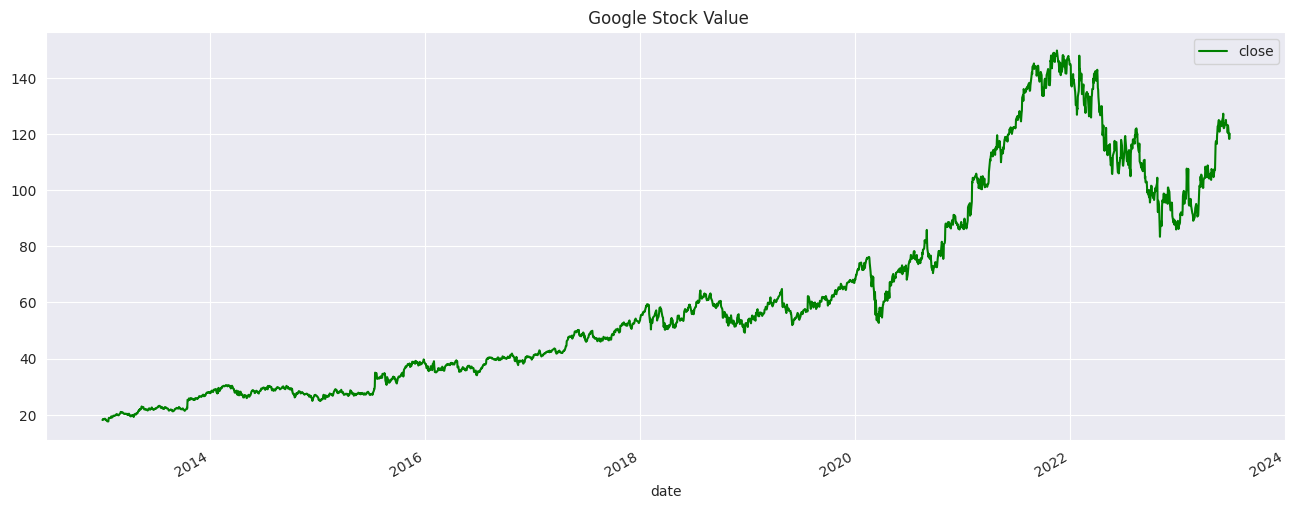

In [47]:
#plot the mean stock prices for the current dataset and lock the trends from df

main_dataset['close'].plot(color='green', figsize=(16, 6))
plt.legend(['close'])
plt.title(" Google Stock Value")

Text(0.5, 1.0, ' Google Stock Volume')

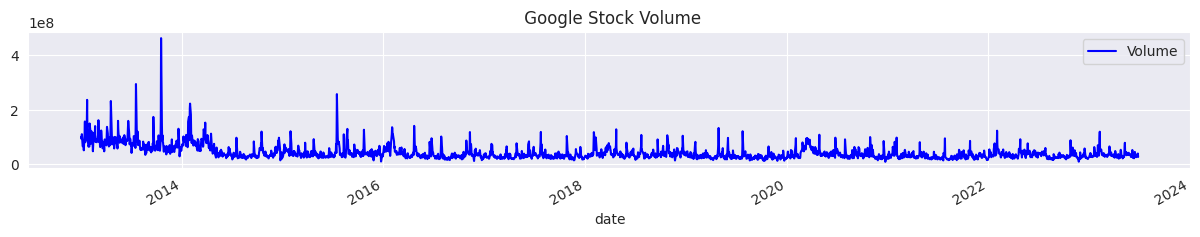

In [48]:
#Plotting volume of Apple stocks sold daily from df

main_dataset['volume'].plot(color='blue', figsize=(15, 2))
plt.legend(['Volume'])
plt.title(" Google Stock Volume")

In [49]:
test_close = main_dataset[['close']]
test_close.head(4)

,close
date,
2013-01-02,18.099348
2013-01-03,18.109859
2013-01-04,18.467718
2013-01-07,18.387136


In [50]:
test_actual = main_dataset[['close',
                            'Next date']]
test_actual.tail(10)

,close,Next date
date,,
2023-06-14,123.669998,125.089996
2023-06-15,125.089996,123.529999
2023-06-16,123.529999,123.099998
2023-06-20,123.099998,120.550003
2023-06-21,120.550003,123.150002
2023-06-22,123.150002,122.339996
2023-06-23,122.339996,118.339996
2023-06-26,118.339996,118.330002
2023-06-27,118.330002,120.180000


In [51]:
#Normalizing the input and target features
#Since the stock prices and volume are on a different scale, we need to normalize the data. We use StandardScaler to normalize the data. The scaler is fit on the training set and then applied to the test set. This means we need to fit the scaler on the training set and apply the same scaler to the test set.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(main_dataset[['low', 'high', 'open', 'close', 'volume',
                                                 'NATR_3', 'RSI_3', 'ADX_3', 'CCI_3_0.015',
                                                 'ROC_3','STOCHk_14_3_3', 'STOCHd_14_3_3',
                                                 'WILLR_3','OBV', 'MACD_12_26_9', 'BBL_3_2.0',
                                                 'BBM_3_2.0','BBU_3_2.0', 'BBB_3_2.0',
                                                 'BBP_3_2.0', 'min_price_3', 'max_price_3',
                                                 'mid_price', 'tema_2', 'tema_100','tema_8','adj_close']])
# scaled_data = scaler.fit_transform(main_dataset[["close", 'Next date']])
scaled_data = pd.DataFrame(scaled_data)

X = scaled_data
X.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
2637,1.646003,1.674670,1.678611,1.608811,-0.323501,0.729151,-1.399626,0.781806,-1.325661,-0.726996,...,1.740114,1.193596,-1.399542,1.686671,1.675107,1.660615,1.613288,1.831267,1.653543,1.608811
2638,1.583663,1.592818,1.574170,1.608528,-0.114000,0.541185,-1.401246,1.326870,-1.174848,-1.450177,...,1.683625,0.976584,-0.757186,1.623527,1.662632,1.588395,1.604333,1.830692,1.617999,1.608528
2639,1.605209,1.629539,1.574454,1.661014,-0.582403,0.626127,-0.216063,0.668778,0.278322,-0.703464,...,1.607150,-0.199774,1.229136,1.623527,1.640732,1.617623,1.657668,1.833034,1.626785,1.661014


In [52]:
#Scaling the target feature
scaler_target = StandardScaler()
scaled_target = scaler_target.fit_transform(main_dataset[['Next date']])
scaled_target = pd.DataFrame(scaled_target)

Y = scaled_target
Y.tail(3)

,0
2637,1.607099
2638,1.659573
2639,1.628939


In [53]:
#rename X

X.rename(columns={0:'open', 1:'high', 2:'low', 3:'close', 4:'volume', 5:'NATR_3', 6:'RSI_3', 7:'ADX_3', 8:'CCI_3_0.015',
                  9:'ROC_3', 10:'STOCHk_14_3_3', 11:'STOCHd_14_3_3', 12:'WILLR_3',13:'OBV', 14:'MACD_12_26_9',
                  15:'BBL_3_2.0', 16:'BBM_3_2.0', 17:'BBU_3_2.0', 18:'BBB_3_2.0', 19:'BBP_3_2.0', 20:'min_price_3',
                  21:'max_price_3', 22:'mid_price', 23:'tema_2', 24:'tema_100',25:'tema_8', 26:'adj_close'}, inplace=True)
X.index=main_dataset.index
X.tail(3)

,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,adj_close
date,,,,,,,,,,,,,,,,,,,,,
2023-06-26,1.646003,1.674670,1.678611,1.608811,-0.323501,0.729151,-1.399626,0.781806,-1.325661,-0.726996,...,1.740114,1.193596,-1.399542,1.686671,1.675107,1.660615,1.613288,1.831267,1.653543,1.608811
2023-06-27,1.583663,1.592818,1.574170,1.608528,-0.114000,0.541185,-1.401246,1.326870,-1.174848,-1.450177,...,1.683625,0.976584,-0.757186,1.623527,1.662632,1.588395,1.604333,1.830692,1.617999,1.608528
2023-06-28,1.605209,1.629539,1.574454,1.661014,-0.582403,0.626127,-0.216063,0.668778,0.278322,-0.703464,...,1.607150,-0.199774,1.229136,1.623527,1.640732,1.617623,1.657668,1.833034,1.626785,1.661014


In [55]:
#rename Y

Y.rename(columns={0:'Next date'}, inplace=True)
Y.index=main_dataset.index
Y.tail(3)

,Next date
date,
2023-06-26,1.607099
2023-06-27,1.659573
2023-06-28,1.628939


In [56]:
#Get the dataset for validation from df
df_for_validation = X.loc['2023-01-01':'2023-06-28']
df_for_validation.tail(3)

,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,adj_close
date,,,,,,,,,,,,,,,,,,,,,
2023-06-26,1.646003,1.674670,1.678611,1.608811,-0.323501,0.729151,-1.399626,0.781806,-1.325661,-0.726996,...,1.740114,1.193596,-1.399542,1.686671,1.675107,1.660615,1.613288,1.831267,1.653543,1.608811
2023-06-27,1.583663,1.592818,1.574170,1.608528,-0.114000,0.541185,-1.401246,1.326870,-1.174848,-1.450177,...,1.683625,0.976584,-0.757186,1.623527,1.662632,1.588395,1.604333,1.830692,1.617999,1.608528
2023-06-28,1.605209,1.629539,1.574454,1.661014,-0.582403,0.626127,-0.216063,0.668778,0.278322,-0.703464,...,1.607150,-0.199774,1.229136,1.623527,1.640732,1.617623,1.657668,1.833034,1.626785,1.661014


In [57]:
df_for_validation_actual = Y.loc['2023-01-01':'2023-06-28']
df_for_validation_actual.head(2)

,Next date
date,
2023-01-03,0.749063
2023-01-04,0.695737


In [58]:
#Get the train from X between 2013-01-01 and 2022-12-31

X = X.loc['2013-01-01':'2022-12-31']
X.last('3D')

,open,high,low,close,volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,adj_close
date,,,,,,,,,,,,,,,,,,,,,
2022-12-28,0.717220,0.722724,0.719915,0.691865,-0.867266,0.441028,-1.366137,-0.914524,-1.325661,-0.778929,...,0.760619,0.871768,-1.179035,0.74591,0.741140,0.720050,0.692006,0.783714,0.701037,0.691865
2022-12-29,0.736468,0.745429,0.709698,0.760806,-0.723849,0.680160,0.052633,-1.518771,0.667700,-0.393632,...,0.735627,0.367825,1.000289,0.74591,0.724229,0.741049,0.756325,0.776256,0.722339,0.760806
2022-12-30,0.735319,0.730012,0.719915,0.754564,-0.699278,0.339802,-0.074949,-1.882139,0.308866,0.244293,...,0.749089,0.525610,0.471900,0.74591,0.721734,0.732678,0.756928,0.768843,0.734062,0.754564


In [59]:
Y = Y.loc['2013-01-01':'2022-12-31']
Y.last('3D')

,Next date
date,
2022-12-28,0.759558
2022-12-29,0.753318
2022-12-30,0.778563


In [60]:
#Splitting the dataset into training and testing sets

temp_df = main_dataset.loc['2013-01-01':'2022-12-31']

train_size = int(len(temp_df) * 0.80)
test_size = int(len(temp_df) - train_size)
print(test_size)

504


In [61]:
#Splitting the dataset into training and testing sets using train_size and test_size from df and y respectively
train_X, train_Y = X[:train_size].dropna(), Y[:train_size].dropna()
test_X, test_Y = X[train_size:].dropna(), Y[train_size:].dropna()

In [62]:
test_X.columns

Index(['open', 'high', 'low', 'close', 'volume', 'NATR_3', 'RSI_3', 'ADX_3',
       'CCI_3_0.015', 'ROC_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'WILLR_3',
       'OBV', 'MACD_12_26_9', 'BBL_3_2.0', 'BBM_3_2.0', 'BBU_3_2.0',
       'BBB_3_2.0', 'BBP_3_2.0', 'min_price_3', 'max_price_3', 'mid_price',
       'tema_2', 'tema_100', 'tema_8', 'adj_close'],
      dtype='object')

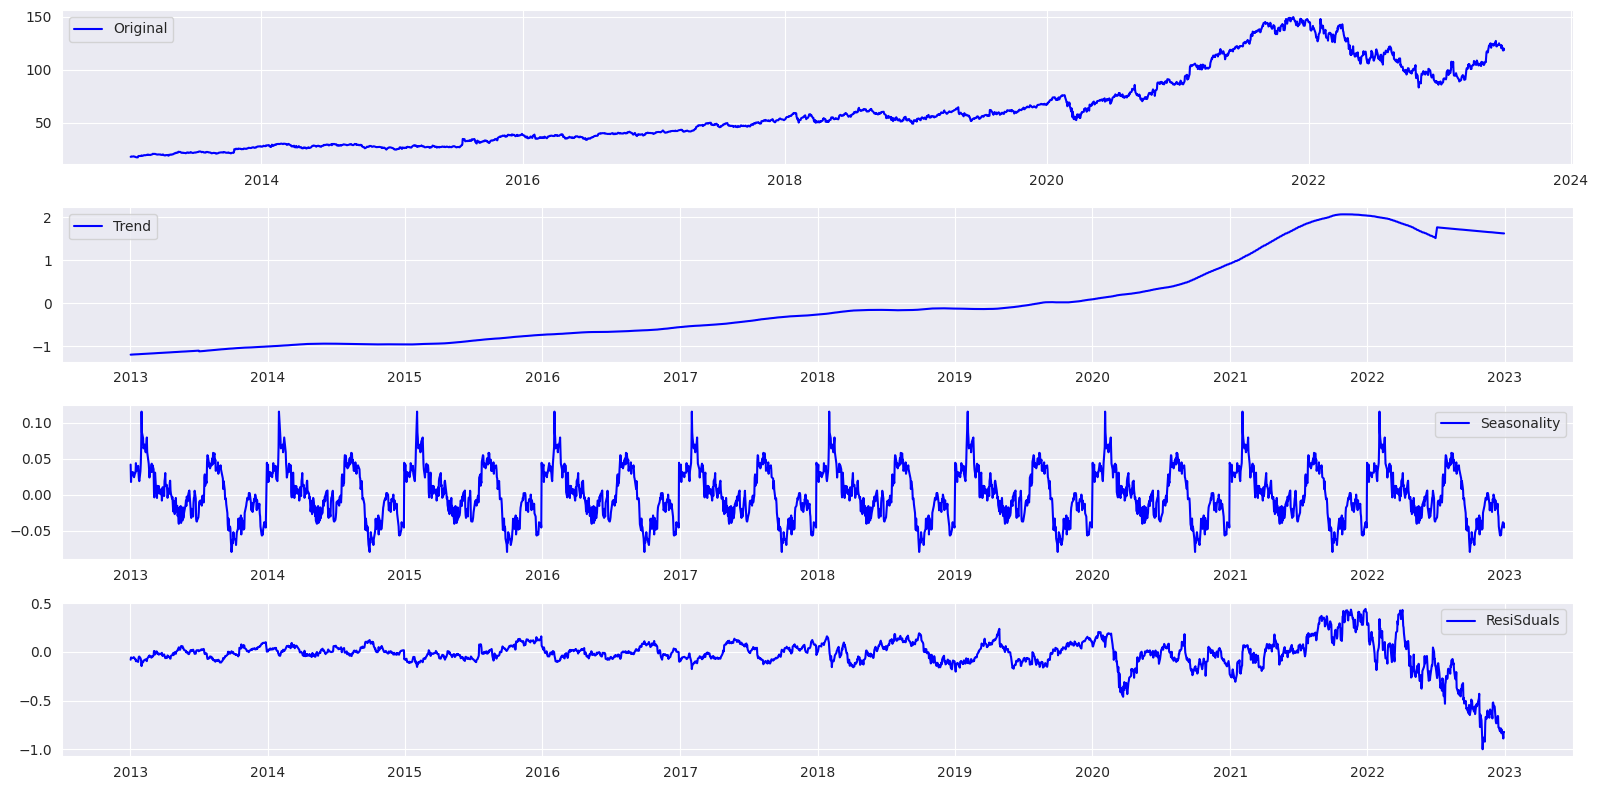

In [63]:
from statsmodels.tsa.stattools import acf
# ###Understanding the Time series data
# Decomposing Time Series into several components-Trend, Seasonality, and Random noise
#
# We know that Time series data is composed of Level, Trend, Seasonality, and Random noise. Let’s decompose the data and plot the trend, seasonality, and randomness in the data.
#
# We use statsmodel for seasonal decompose as an additive model and the frequency of the time series, which is the periodicity of the data, which is 365 days for yearly data.
#
# Additive model = Trend + Seasonality + Random Noise

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(X['close'], model='add', period=252, extrapolate_trend='freq', two_sided=True, filt=None)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(df['close'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='ResiSduals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [64]:
###Check for Data Stationarity using Augmented Dickey-Fuller(ADF) test.

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

def test_adf(series, title=''):
    dfout={}
    dftest = sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is  Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)


In [65]:
#Checking for stationary in the data using the ADF test

y_test = Y['Next date'][:train_size].dropna()
test_adf(y_test, 'Next date')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is  Stationary
Data is Stationary Next date


In [66]:
#Make the data stationary by differencing the data
y_test_diff = y_test.diff().dropna()
test_adf(y_test_diff, 'Stock Price Next Day')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is  Stationary
Data is Stationary Stock Price Next Day


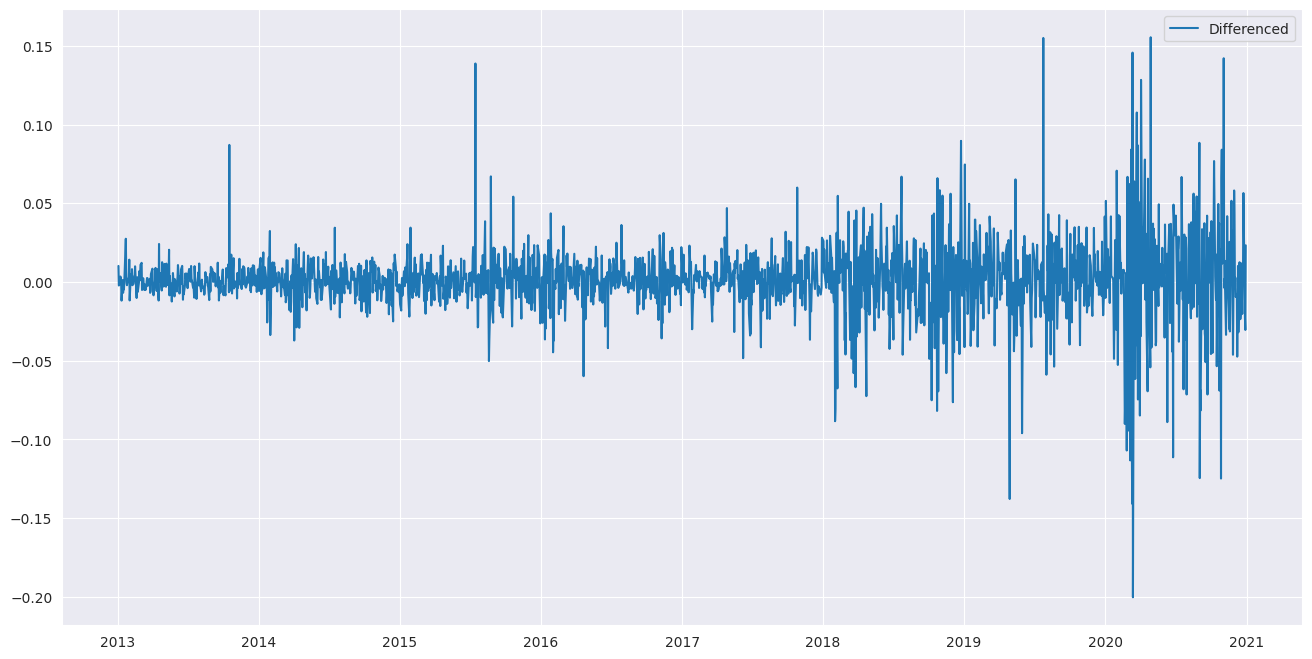

In [67]:
#Plotting the differenced data

plt.figure(figsize=(16, 8))
plt.plot(y_test_diff, label='Differenced')
plt.legend(loc='best')
plt.show()

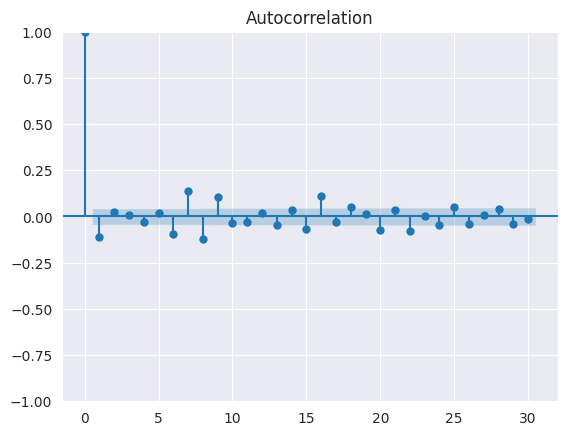

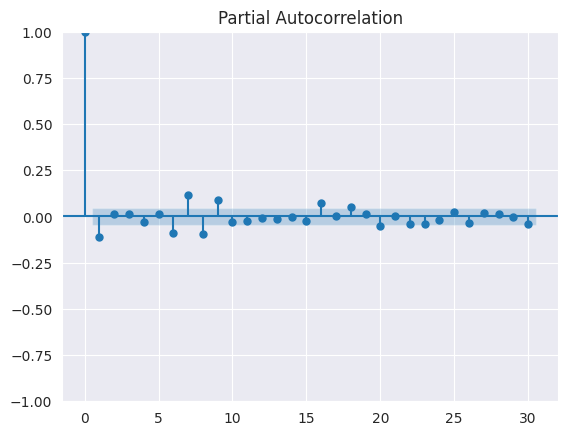

In [68]:
#Plotting the autocorrelation plot for the differenced data

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y_test_diff, lags=30)
plot_pacf(y_test_diff, lags=30)
plt.show()

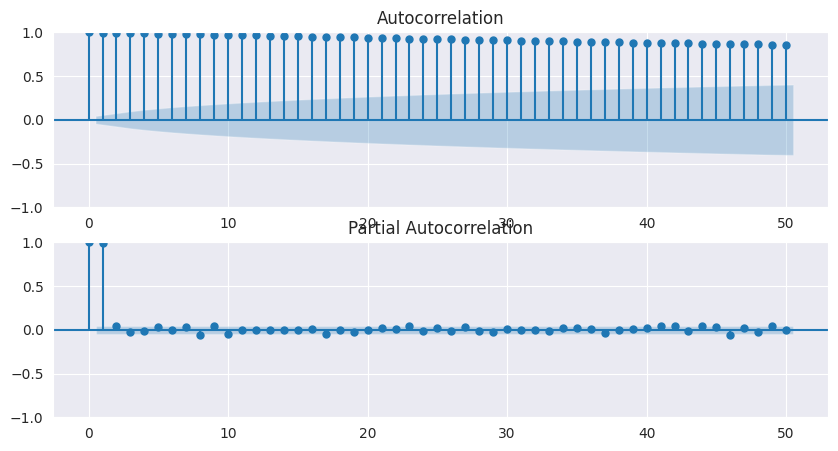

In [69]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [70]:
#Get only tema_2 from train_X, test_X

train_X_with_tema_2 = train_X.drop(['tema_8', 'tema_100'], axis=1)
text_X_with_tema_2 = test_X.drop(['tema_8' , 'tema_100'], axis=1)

train_X_with_tema_2.columns

Index(['open', 'high', 'low', 'close', 'volume', 'NATR_3', 'RSI_3', 'ADX_3',
       'CCI_3_0.015', 'ROC_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'WILLR_3',
       'OBV', 'MACD_12_26_9', 'BBL_3_2.0', 'BBM_3_2.0', 'BBU_3_2.0',
       'BBB_3_2.0', 'BBP_3_2.0', 'min_price_3', 'max_price_3', 'mid_price',
       'tema_2', 'adj_close'],
      dtype='object')

In [71]:
#Get only tema_8 from train_X, test_X

train_X_with_tema_8 = train_X.drop(['tema_2', 'tema_100'], axis=1)
text_X_with_tema_8 = test_X.drop(['tema_2', 'tema_100'], axis=1)

train_X_with_tema_8.columns

Index(['open', 'high', 'low', 'close', 'volume', 'NATR_3', 'RSI_3', 'ADX_3',
       'CCI_3_0.015', 'ROC_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'WILLR_3',
       'OBV', 'MACD_12_26_9', 'BBL_3_2.0', 'BBM_3_2.0', 'BBU_3_2.0',
       'BBB_3_2.0', 'BBP_3_2.0', 'min_price_3', 'max_price_3', 'mid_price',
       'tema_8', 'adj_close'],
      dtype='object')

In [72]:
#Get only tema_100 from train_X, test_X

train_X_with_tema_100 = train_X.drop(['tema_2', 'tema_8'], axis=1)
text_X_with_tema_100 = test_X.drop(['tema_2', 'tema_8'], axis=1)

train_X_with_tema_100.columns

Index(['open', 'high', 'low', 'close', 'volume', 'NATR_3', 'RSI_3', 'ADX_3',
       'CCI_3_0.015', 'ROC_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'WILLR_3',
       'OBV', 'MACD_12_26_9', 'BBL_3_2.0', 'BBM_3_2.0', 'BBU_3_2.0',
       'BBB_3_2.0', 'BBP_3_2.0', 'min_price_3', 'max_price_3', 'mid_price',
       'tema_100', 'adj_close'],
      dtype='object')

In [73]:
#Get df without tema from train_X, test_X

train_X_without_tema = train_X.drop(['tema_2', 'tema_8', 'tema_100'], axis=1)
text_X_without_tema = test_X.drop(['tema_2', 'tema_8', 'tema_100'], axis=1)

text_X_without_tema.columns

Index(['open', 'high', 'low', 'close', 'volume', 'NATR_3', 'RSI_3', 'ADX_3',
       'CCI_3_0.015', 'ROC_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'WILLR_3',
       'OBV', 'MACD_12_26_9', 'BBL_3_2.0', 'BBM_3_2.0', 'BBU_3_2.0',
       'BBB_3_2.0', 'BBP_3_2.0', 'min_price_3', 'max_price_3', 'mid_price',
       'adj_close'],
      dtype='object')

In [74]:
#Get the best parameters of seasonal orders for the SAIRMAX model using the auto_arima function from pmdarima library.

from pmdarima.arima import auto_arima

stepwise_model = auto_arima(train_Y, exogenous=train_X, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=True,
                            d=1, D =1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=12.35 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-8023.637, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-8535.652, Time=1.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=7.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-8033.373, Time=0.34 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-8837.628, Time=4.49 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=26.22 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=7.07 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-8815.626, Time=5.91 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-8840.995, Time=8.38 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-8538.017, Time=2.86 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=30.51 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=11.71 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-8840.644, Time=5.46 sec
 ARIMA(2,1,1)(2,1,0)[12]             

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2014
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                4451.335
Date:                             Sat, 15 Jul 2023   AIC                          -8888.669
Time:                                     18:29:51   BIC                          -8849.459
Sample:                                          0   HQIC                         -8874.273
                                            - 2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9734      0.028    -34.554      0.000      -1.029      -0.918
ar.L2         -0.0304      0.020     -1.556      0.120      -0.069       0.008
ar.L3          0.1352      0.014      9.415      0.000       0.107       0.163
ma.L1          0.8757      0.027     32.783      0.000       0.823       0.928
ar.S.L12      -0.6630      0.013    -50.315      0.000      -0.689      -0.637
ar.S.L24      -0.3848      0.013    -29.603      0.000      -0.410      -0.359
sigma2         0.0007   1.01e-05     65.707      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.79   Jarque-Bera (JB):              3927.14
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               7.83   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
#set the order and seasonal order for all project

#Average Mean Absolute Percentage Error:  9.007967559508627 (tema_2), 9.494701458098493 (tema_8), 10.553632591175544 (tema_100)
# order = (1, 1, 1)
# seasonal_order = (2, 1, 0, 12)
#ARIMA(2,1,0)(2,1,0)[12]

#Average Mean Absolute Percentage Error:  8.929140381017902(tema_2), 9.432941139268372 (tema_8), tema_100
order = (2, 1, 0)
seasonal_order = (2, 1, 0, 12)

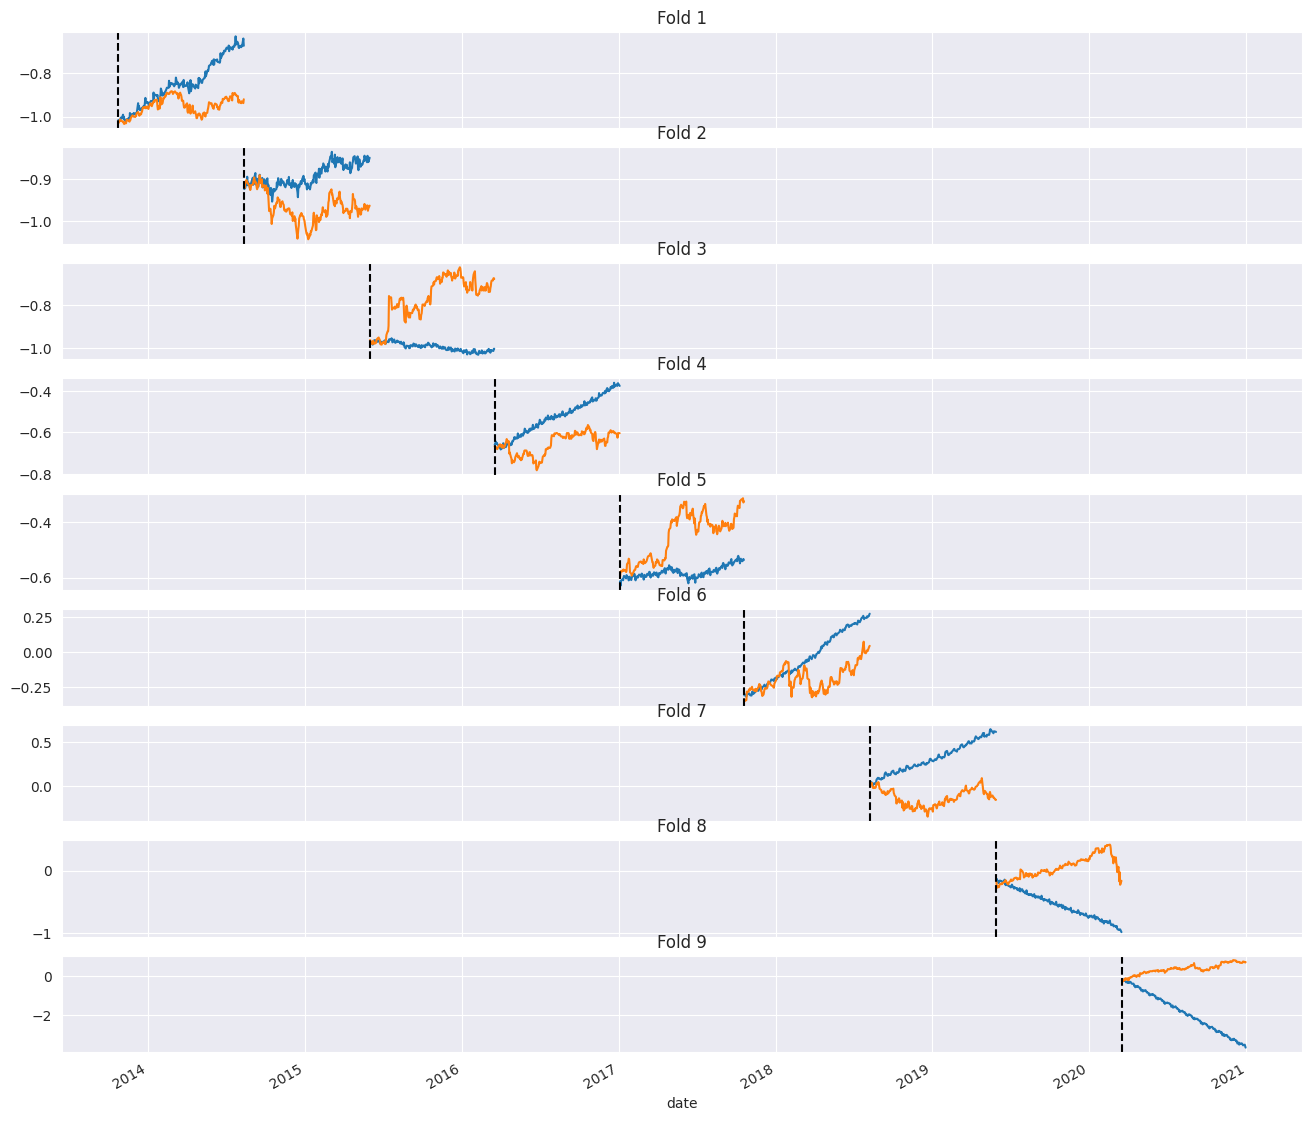

Average Mean Absolute Percentage Error:  7.047409167865988


In [90]:
#Time series cross validation using TimeSeriesSplit from sklearn.model_selection library and mean_absolute_percentage_error from sklearn.metrics library. We use the SARIMAX model to fit the data and predict the values for the test data. We then calculate the mean
#absolute percentage error for the predicted values and the actual values. We then plot the predicted values and the actual values. We also plot the residuals of the model.

##using tema_2
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

total_samples = len(train_X_with_tema_2)  # Mỗi mẫu tương ứng với một năm

test_size_ratio = 0.1  # Tỷ lệ phần trăm dùng cho tập kiểm tra
test_size = int(total_samples * test_size_ratio)
tscv = TimeSeriesSplit(n_splits=9, test_size=test_size, gap=0)

train_X_with_tema_2 = train_X_with_tema_2.sort_index()
train_Y = train_Y.sort_index()
# print(train_X.head())
figure, ax = plt.subplots(9, 1 , figsize=(16, 15), sharex=True)
fold = 0
the_average_mape = 0


for train_index, test_index in tscv.split(train_X_with_tema_2):
    X_train, X_test = train_X_with_tema_2.iloc[train_index], train_X_with_tema_2.iloc[test_index]
    y_train, y_test = train_Y.iloc[train_index], train_Y.iloc[test_index]

    #turn off the output of the model
    model = SARIMAX(endog=y_train, exog=X_train, order=order, seasonal_order=seasonal_order)

    model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=False)
    y_pred = model_fit.forecast(steps=len(X_test), exog=X_test)

    y_pred.reset_index(drop=True, inplace=True)
    result = pd.DataFrame(y_pred)
    result.reset_index(drop=True, inplace=True)
    result.index=X_test.index
    result["Next date"] = y_test
    ##plot the predicted and actual values from y_pred and x_test
    result["predicted_mean"].plot(ax=ax[fold], label='Predicted Set', title='Fold {}'.format(fold+1))
    result["Next date"].plot(ax=ax[fold], label='Actual Set')
    ax[fold].axvline(X_test.index.min(), color='black', ls='--')
    fold+= 1

    mape = mean_absolute_percentage_error(y_test, y_pred)
    the_average_mape = the_average_mape + mape

plt.show()
print("Average Mean Absolute Percentage Error: ", the_average_mape/5)

In [91]:
#Predicting the values in the validation data using the SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

model = SARIMAX(endog=train_Y, exog=train_X_with_tema_2, order=order, seasonal_order=seasonal_order, enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=True)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Next date   No. Observations:                 2014
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                4413.374
Date:                            Sat, 15 Jul 2023   AIC                          -8766.747
Time:                                    19:03:55   BIC                          -8599.098
Sample:                                         0   HQIC                         -8705.151
                                           - 2014                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
open              0.1527      0.045      3.412      0.001       0.065       0.240
high              0.3106  

In [92]:
#Predicting the values in the validation data using the SARIMAX model
df_for_validation_with_tema_2 = df_for_validation.drop(['tema_8', 'tema_100'], axis=1)
forecast = model_fit.forecast(steps=len(df_for_validation_with_tema_2), exog=df_for_validation_with_tema_2)

In [93]:
#Plotting the forecasted values

forecast_google_with_tema_2= pd.DataFrame(forecast)
forecast_google_with_tema_2.reset_index(drop=True, inplace=True)
forecast_google_with_tema_2.index=df_for_validation_actual.index
forecast_google_with_tema_2["Actual"] =df_for_validation_actual
forecast_google_with_tema_2.rename(columns={0:"predicted_close"}, inplace=True)

<Axes: xlabel='date'>

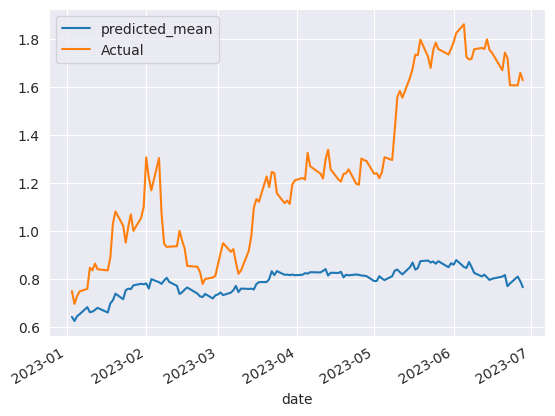

In [94]:
forecast_google_with_tema_2["predicted_mean"].plot(legend=True)
forecast_google_with_tema_2["Actual"].plot(legend=True)

In [95]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

error=rmse(forecast_google_with_tema_2["predicted_mean"], forecast_google_with_tema_2["Actual"])
print("The root mean squared error is {}.".format(error))

##calculate the mean absolute percentage error

mape = mean_absolute_percentage_error(forecast_google_with_tema_2["Actual"], forecast_google_with_tema_2["predicted_mean"])
print("The mean absolute percentage error is {}.".format(mape))

The root mean squared error is 0.5428397887077614.
The mean absolute percentage error is 0.3303791202579208.


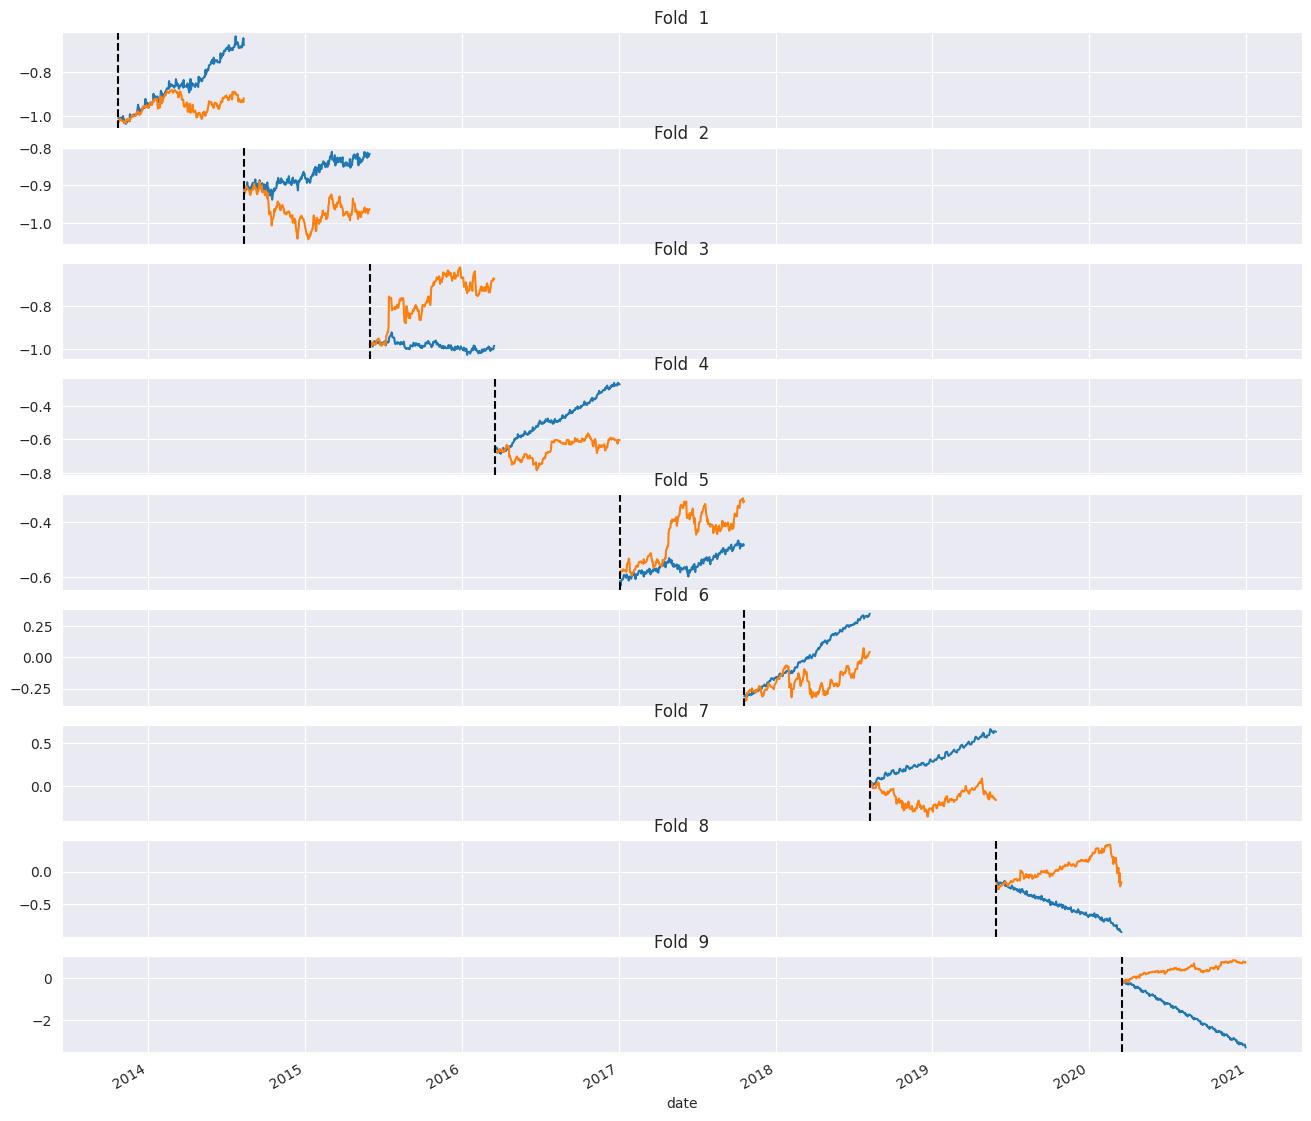

Average Mean Absolute Percentage Error:  6.987409730654726


In [96]:
#Time series cross validation using TimeSeriesSplit from sklearn.model_selection library and mean_absolute_percentage_error from sklearn.metrics library. We use the SARIMAX model to fit the data and predict the values for the test data. We then calculate the mean
#absolute percentage error for the predicted values and the actual values. We then plot the predicted values and the actual values. We also plot the residuals of the model.

##using tema_8

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

total_samples = len(train_X_with_tema_8)  # Mỗi mẫu tương ứng với một năm

test_size_ratio = 0.1  # Tỷ lệ phần trăm dùng cho tập kiểm tra
test_size = int(total_samples * test_size_ratio)
tscv = TimeSeriesSplit(n_splits=9, test_size=test_size, gap=0)

train_X_with_tema_8 = train_X_with_tema_8.sort_index()
train_Y = train_Y.sort_index()
# print(train_X.head())
figure, ax = plt.subplots(9, 1 , figsize=(16, 15), sharex=True)
fold = 0
the_average_mape = 0

for train_index, test_index in tscv.split(train_X_with_tema_8):
    X_train, X_test = train_X_with_tema_8.iloc[train_index], train_X_with_tema_8.iloc[test_index]
    y_train, y_test = train_Y.iloc[train_index], train_Y.iloc[test_index]

    #turn off the output of the model
    model = SARIMAX(endog=y_train, exog=X_train, order=order, seasonal_order=seasonal_order)

    model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=False)
    y_pred = model_fit.forecast(steps=len(X_test), exog=X_test)

    y_pred.reset_index(drop=True, inplace=True)
    result = pd.DataFrame(y_pred)
    result.reset_index(drop=True, inplace=True)
    result.index=X_test.index
    result["Next date"] = y_test
    ##plot the predicted and actual values from y_pred and x_test
    result["predicted_mean"].plot(ax=ax[fold], label='Predicted Set', title='Fold  {}'.format(fold+1))
    result["Next date"].plot(ax=ax[fold], label='Actual Set')
    ax[fold].axvline(X_test.index.min(), color='black', ls='--')
    fold+= 1

    mape = mean_absolute_percentage_error(y_test, y_pred)
    the_average_mape = the_average_mape + mape

plt.show()
print("Average Mean Absolute Percentage Error: ", the_average_mape/5)

In [97]:
#Predicting the values in the validation data using the SARIMAX model
model = SARIMAX(endog=train_Y, exog=train_X_with_tema_8, order=order, seasonal_order=seasonal_order,
                enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=True)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Next date   No. Observations:                 2014
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                4417.858
Date:                            Sat, 15 Jul 2023   AIC                          -8775.715
Time:                                    19:31:21   BIC                          -8608.065
Sample:                                         0   HQIC                         -8714.118
                                           - 2014                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
open              0.2065      0.046      4.477      0.000       0.116       0.297
high              0.4384  

In [98]:
#Predicting the values in the validation data using the SARIMAX model
df_for_validation_with_tema_8 = df_for_validation.drop(['tema_2', 'tema_100'], axis=1)
forecast = model_fit.forecast(steps=len(df_for_validation_with_tema_8), exog=df_for_validation_with_tema_8)

<Axes: xlabel='date'>

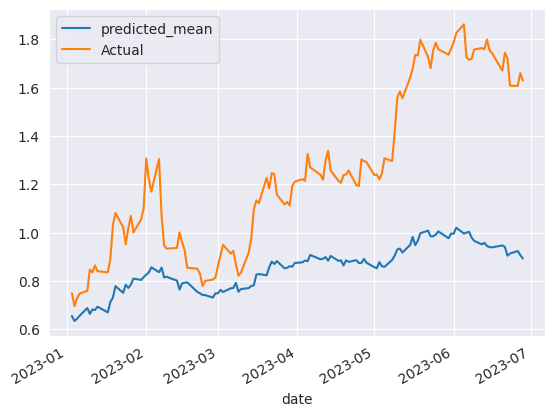

In [99]:
#Plotting the forecasted values

forecast_google_with_tema_8 = pd.DataFrame(forecast)
forecast_google_with_tema_8.reset_index(drop=True, inplace=True)
forecast_google_with_tema_8.index = df_for_validation_actual.index
forecast_google_with_tema_8["Actual"] = df_for_validation_actual
forecast_google_with_tema_8.rename(columns={0: "predicted_close"}, inplace=True)
forecast_google_with_tema_8["predicted_mean"].plot(legend=True)
forecast_google_with_tema_8["Actual"].plot(legend=True)

In [100]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

error=rmse(forecast_google_with_tema_8["predicted_mean"], forecast_google_with_tema_8["Actual"])
print("The root mean squared error is {}.".format(error))

##calculate the mean absolute percentage error

mape = mean_absolute_percentage_error(forecast_google_with_tema_8["Actual"], forecast_google_with_tema_8["predicted_mean"])
print("The mean absolute percentage error is {}.".format(mape))

The root mean squared error is 0.4664002270279034.
The mean absolute percentage error is 0.2853007575476174.


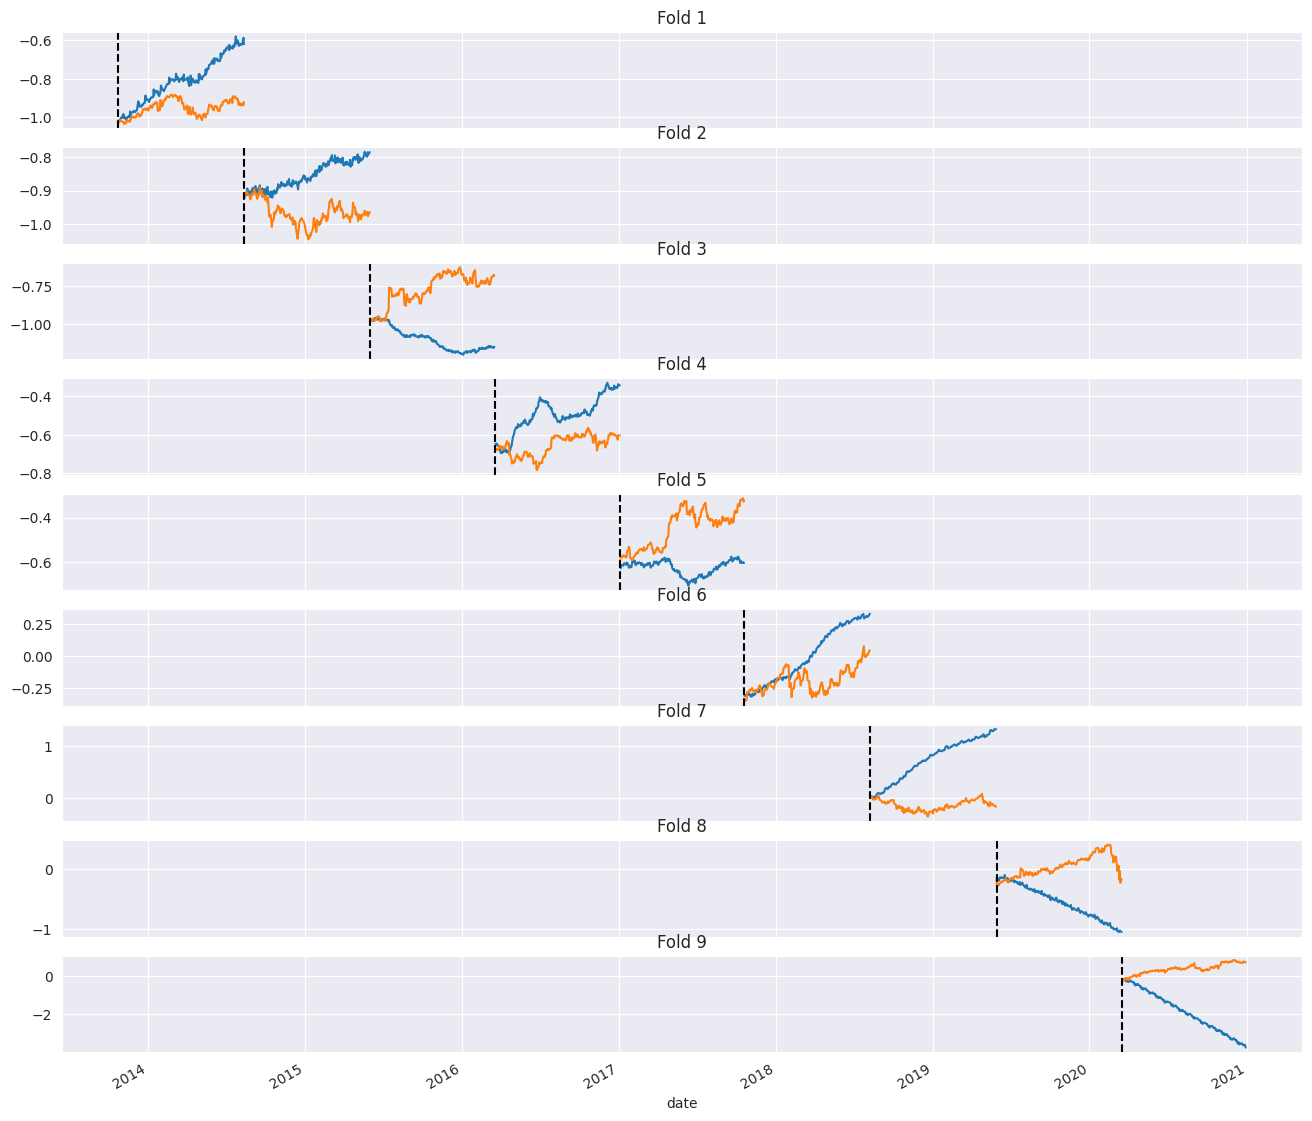

Average Mean Absolute Percentage Error:  8.591311060936661


In [102]:
#Time series cross validation using TimeSeriesSplit from sklearn.model_selection library and mean_absolute_percentage_error from sklearn.metrics library. We use the SARIMAX model to fit the data and predict the values for the test data. We then calculate the mean
#absolute percentage error for the predicted values and the actual values. We then plot the predicted values and the actual values. We also plot the residuals of the model.

##using tema_100
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

total_samples = len(train_X_with_tema_100)  # Mỗi mẫu tương ứng với một năm

test_size_ratio = 0.1  # Tỷ lệ phần trăm dùng cho tập kiểm tra
test_size = int(total_samples * test_size_ratio)
tscv = TimeSeriesSplit(n_splits=9, test_size=test_size, gap=0)

train_X_with_tema_100 = train_X_with_tema_100.sort_index()
train_Y = train_Y.sort_index()
# print(train_X.head())
figure, ax = plt.subplots(9, 1 , figsize=(16, 15), sharex=True)
fold = 0
the_average_mape = 0

for train_index, test_index in tscv.split(train_X_with_tema_100):
    X_train, X_test = train_X_with_tema_100.iloc[train_index], train_X_with_tema_100.iloc[test_index]
    y_train, y_test = train_Y.iloc[train_index], train_Y.iloc[test_index]

    #turn off the output of the model
    model = SARIMAX(endog=y_train, exog=X_train, order=order, seasonal_order=seasonal_order)

    model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=False)
    y_pred = model_fit.forecast(steps=len(X_test), exog=X_test)

    result = pd.DataFrame(y_pred)
    result.reset_index(drop=True, inplace=True)
    result.index=X_test.index
    result["Next date"] = y_test
    ##plot the predicted and actual values from y_pred and x_test
    result["predicted_mean"].plot(ax=ax[fold], label='Predicted Set', title='Fold {}'.format(fold+1))
    result["Next date"].plot(ax=ax[fold], label='Actual Set')
    ax[fold].axvline(X_test.index.min(), color='black', ls='--')
    fold+= 1

    mape = mean_absolute_percentage_error(y_test, y_pred)
    the_average_mape = the_average_mape + mape

plt.show()
print("Average Mean Absolute Percentage Error: ", the_average_mape/5)

In [103]:
#Predicting the values in the validation data using the SARIMAX model
model = SARIMAX(endog=train_Y, exog=train_X_with_tema_100, order=order, seasonal_order=seasonal_order,
                enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=True)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Next date   No. Observations:                 2014
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                4414.291
Date:                            Sat, 15 Jul 2023   AIC                          -8768.583
Time:                                    20:04:25   BIC                          -8600.933
Sample:                                         0   HQIC                         -8706.986
                                           - 2014                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
open              0.1062      0.045      2.355      0.019       0.018       0.195
high              0.3229  

In [104]:
#Predicting the values in the validation data using the SARIMAX model
df_for_validation_with_tema_100 = df_for_validation.drop(['tema_2', 'tema_8'], axis=1)
forecast = model_fit.forecast(steps=len(df_for_validation_with_tema_100), exog=df_for_validation_with_tema_100)

<Axes: xlabel='date'>

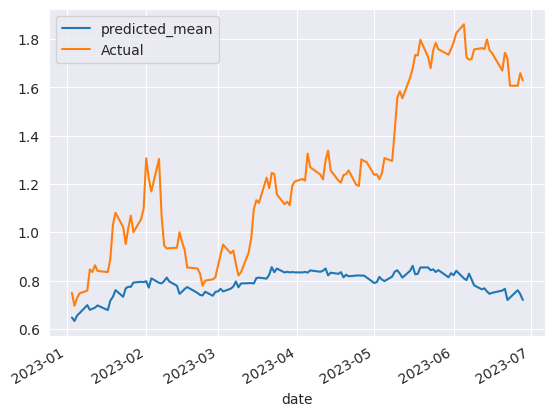

In [105]:
#Plotting the forecasted values

forecast_google_tema_100 = pd.DataFrame(forecast)
forecast_google_tema_100.reset_index(drop=True, inplace=True)
forecast_google_tema_100.index = df_for_validation_actual.index
forecast_google_tema_100["Actual"] = df_for_validation_actual
forecast_google_tema_100.rename(columns={0: "predicted_close"}, inplace=True)
forecast_google_tema_100["predicted_mean"].plot(legend=True)
forecast_google_tema_100["Actual"].plot(legend=True)

In [107]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

error=rmse(forecast_google_tema_100["predicted_mean"], forecast_google_tema_100["Actual"])
print("The root mean squared error is {}.".format(error))

##calculate the mean absolute percentage error

mape = mean_absolute_percentage_error(forecast_google_tema_100["Actual"],
                                      forecast_google_tema_100["predicted_mean"])
print("The mean absolute percentage error is {}.".format(mape))

The root mean squared error is 0.5539797552338066.
The mean absolute percentage error is 0.3255420016419275.


In [ ]:
#Time series cross validation using TimeSeriesSplit from sklearn.model_selection library and mean_absolute_percentage_error from sklearn.metrics library. We use the SARIMAX model to fit the data and predict the values for the test data. We then calculate the mean
#absolute percentage error for the predicted values and the actual values. We then plot the predicted values and the actual values. We also plot the residuals of the model.

##without tema

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

total_samples = len(train_X_without_tema)  # Mỗi mẫu tương ứng với một năm

test_size_ratio = 0.1  # Tỷ lệ phần trăm dùng cho tập kiểm tra
test_size = int(total_samples * test_size_ratio)
tscv = TimeSeriesSplit(n_splits=9, test_size=test_size, gap=0)

train_X_without_tema = train_X_without_tema.sort_index()
train_Y = train_Y.sort_index()
# print(train_X.head())
figure, ax = plt.subplots(9, 1 , figsize=(16, 15), sharex=True)
fold = 0
the_average_mape = 0

for train_index, test_index in tscv.split(train_X_without_tema):
    X_train, X_test = train_X_without_tema.iloc[train_index], train_X_without_tema.iloc[test_index]
    y_train, y_test = train_Y.iloc[train_index], train_Y.iloc[test_index]

    #turn off the output of the model
    model = SARIMAX(endog=y_train, exog=X_train, order=order, seasonal_order=seasonal_order)

    model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=False)
    y_pred = model_fit.forecast(steps=len(X_test), exog=X_test)

    y_pred.reset_index(drop=True, inplace=True)
    result = pd.DataFrame(y_pred)
    result.reset_index(drop=True, inplace=True)
    result.index=X_test.index
    result["Next date"] = y_test
    ##plot the predicted and actual values from y_pred and x_test
    result["predicted_mean"].plot(ax=ax[fold], label='Predicted Set', title='Fold {}'.format(fold+1))
    result["Next date"].plot(ax=ax[fold], label='Actual Set')
    ax[fold].axvline(X_test.index.min(), color='black', ls='--')
    fold+= 1

    mape = mean_absolute_percentage_error(y_test, y_pred)
    the_average_mape = the_average_mape + mape

plt.show()
print("Average Mean Absolute Percentage Error: ", the_average_mape/5)

In [108]:
#Predicting the values in the validation data using the SARIMAX model
model = SARIMAX(endog=train_Y, exog=train_X_without_tema, order=order, seasonal_order=seasonal_order,
                enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit(maxiter=200, method='powell', disp=False, full_output=True)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Next date   No. Observations:                 2014
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                4413.482
Date:                            Sat, 15 Jul 2023   AIC                          -8768.964
Time:                                    20:07:13   BIC                          -8606.903
Sample:                                         0   HQIC                         -8709.421
                                           - 2014                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
open              0.1505      0.045      3.370      0.001       0.063       0.238
high              0.3084  

In [109]:
#Predicting the values in the validation data using the SARIMAX model
df_for_validation_without_tema = df_for_validation.drop(['tema_2', 'tema_8', 'tema_100'], axis=1)
forecast = model_fit.forecast(steps=len(df_for_validation_without_tema), exog=df_for_validation_without_tema)

<Axes: xlabel='date'>

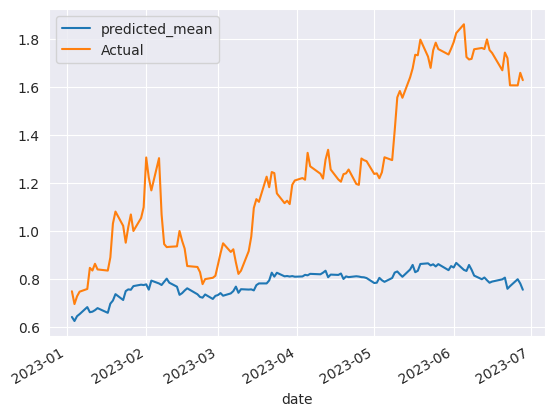

In [110]:
#Plotting the forecasted values

forecast_google_without_tema = pd.DataFrame(forecast)
forecast_google_without_tema.reset_index(drop=True, inplace=True)
forecast_google_without_tema.index = df_for_validation_actual.index
forecast_google_without_tema["Actual"] = df_for_validation_actual
forecast_google_without_tema.rename(columns={0: "predicted_close"}, inplace=True)
forecast_google_without_tema["predicted_mean"].plot(legend=True)
forecast_google_without_tema["Actual"].plot(legend=True)

In [111]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

error=rmse(forecast_google_without_tema["predicted_mean"], forecast_google_without_tema["Actual"])
print("The root mean squared error is {}.".format(error))

##calculate the mean absolute percentage error

mape = mean_absolute_percentage_error(forecast_google_without_tema["Actual"],
                                      forecast_google_without_tema["predicted_mean"])
print("The mean absolute percentage error is {}.".format(mape))

The root mean squared error is 0.5494786655582679.
The mean absolute percentage error is 0.334425655067876.
